# Anemometer calibration

My homebrew anemometer needs to be calibrated.  I have a BT-100 handheld anemometer, which can log via Bluetooth.  I installed that for a short period -- about 4.5 hours -- and am ready to compare the two.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(22,10))
plt.rc("axes", labelweight="bold", labelsize="large",
       titleweight="bold", titlesize=14, titlepad=10)
plt.params = dict(color="0.75", style=".-", markeredgecolor="0.25",
                  markerfacecolor="0.25")

In [2]:
df = pd.read_csv("../data/raw/anemometer/2021-12-25-17-50-40.csv",
                 names=["row", "time", "wind", "temp"],
                 # parse_dates=["time"],
                 # index_col="time",
                 skiprows=2,
)
df
# df.index = df.index.tz_localize("America/Vancouver")
df.drop(axis="columns", columns="row", inplace=True)
df["date"] = "2021-12-25"
df["Datetime"] = pd.to_datetime(df["date"] + ' ' + df["time"])
df = df.set_index('Datetime')
df.index = df.index.tz_localize("America/Vancouver")

df.head()

,time,wind,temp,date
Datetime,,,,
2021-12-25 13:16:22-08:00,13:16:22,0.6,17.9,2021-12-25
2021-12-25 13:16:23-08:00,13:16:23,1.1,17.9,2021-12-25
2021-12-25 13:16:24-08:00,13:16:24,1.0,17.9,2021-12-25
2021-12-25 13:16:25-08:00,13:16:25,0.8,17.9,2021-12-25
2021-12-25 13:16:26-08:00,13:16:26,0.6,17.9,2021-12-25


In [3]:
format = '%Y-%m-%d %H:%M:%S'
df["Datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format=format)

In [4]:
df.tail()

,time,wind,temp,date,Datetime
Datetime,,,,,
2021-12-25 17:49:38-08:00,17:49:38,0.3,-4.4,2021-12-25,2021-12-25 17:49:38
2021-12-25 17:49:39-08:00,17:49:39,0.3,-4.4,2021-12-25,2021-12-25 17:49:39
2021-12-25 17:49:39-08:00,17:49:39,0.3,-4.4,2021-12-25,2021-12-25 17:49:39
2021-12-25 17:49:39-08:00,17:49:39,0.3,-4.4,2021-12-25,2021-12-25 17:49:39
2021-12-25 17:49:39-08:00,17:49:39,0.3,-4.4,2021-12-25,2021-12-25 17:49:39


Okay, so we've got data taken every second, beginning at 13:16:22 and ending at 17:49:39.  All times are PST.

Let's take a look at some initial plots:

<AxesSubplot:xlabel='Datetime'>

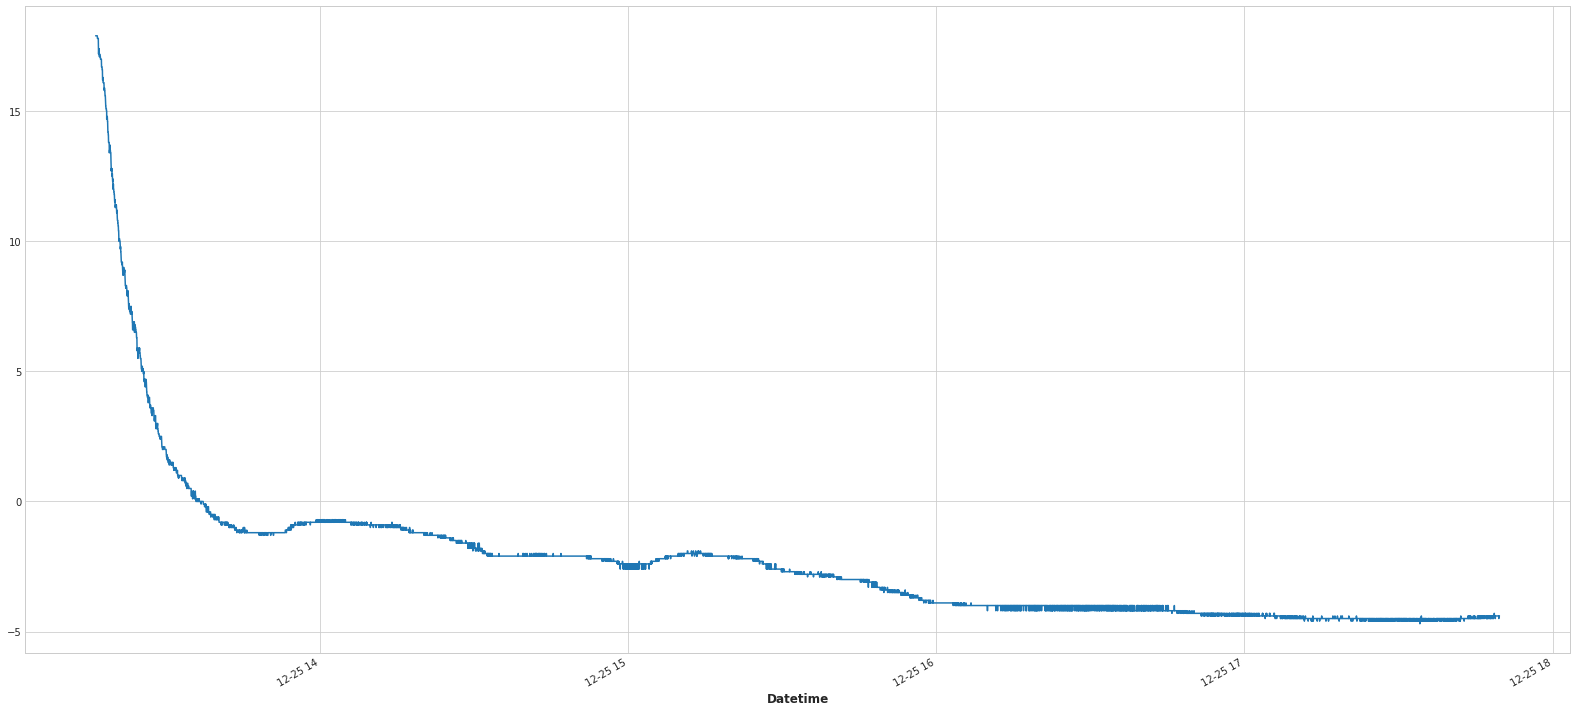

In [5]:
df.temp.plot()

That looks decent.  What about wind?

<AxesSubplot:xlabel='Datetime'>

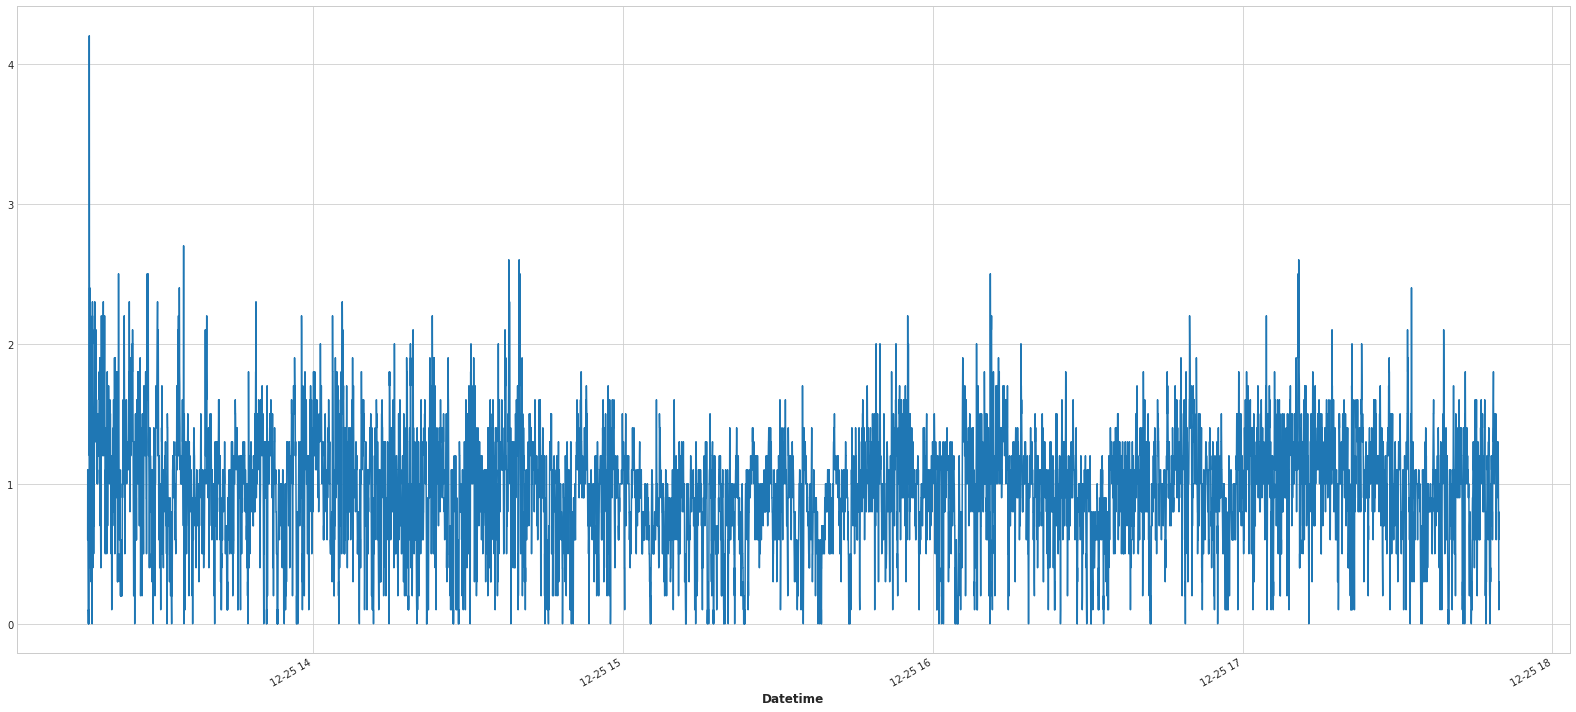

In [6]:
df.wind.plot()

Wind is definitely more noisy.  Not surprising; the plot from Grafana is a 10 minute moving average, and *those* points are in turn from readings taken every 30s.  Let's try making that a moving 10 minute average:

<AxesSubplot:xlabel='Datetime'>

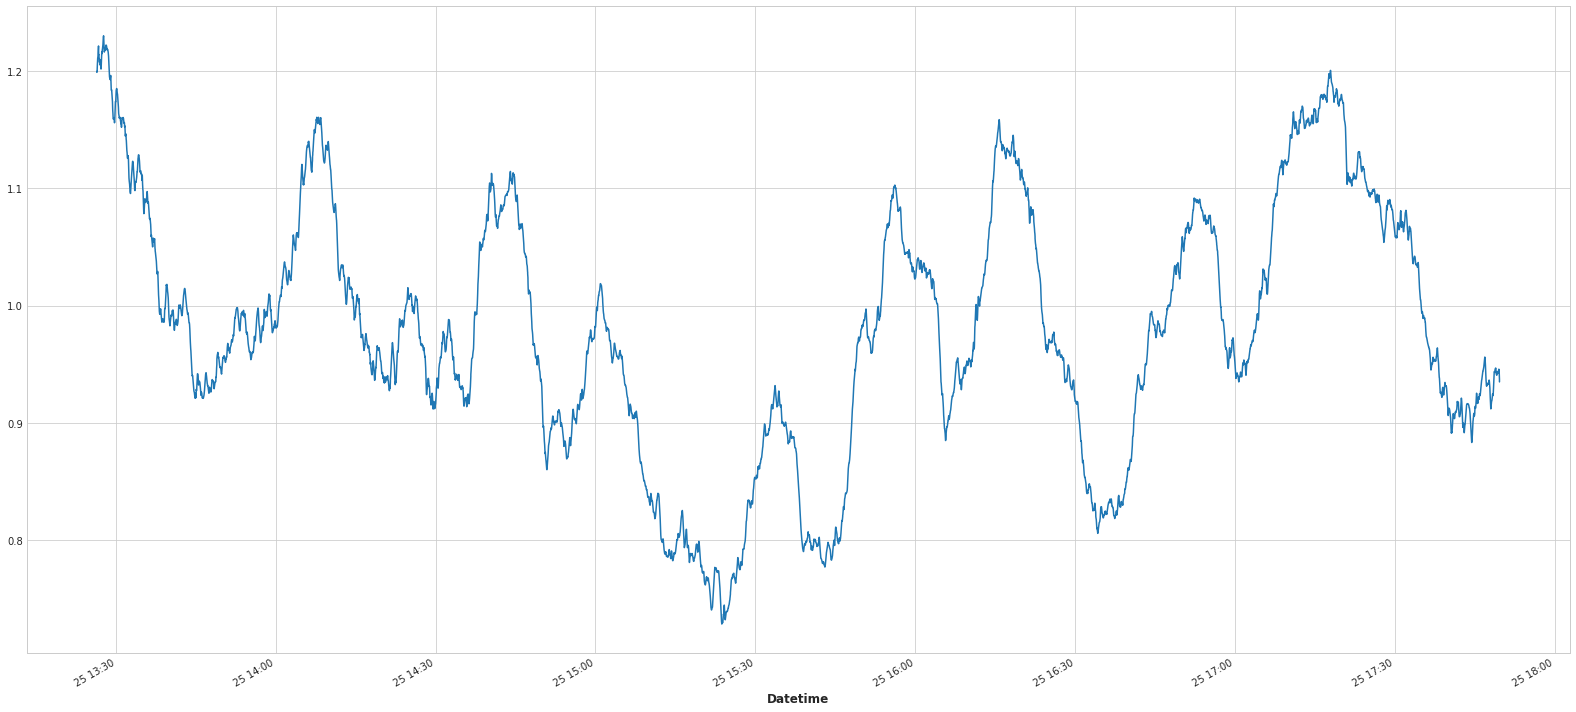

In [7]:
rolling_window = 1 * 60 * 10  # 10 minutes

df["wind_10m_rolling"] = df["wind"].rolling(window=rolling_window).mean()

df["wind_10m_rolling"].plot()

That's better!

One thing to note:

- This data is wind speed, in metres per second, taken every second.
- My homebrew anemometer data is rotations, summed every 30s, from which I derive RPM and then wind speed.

Speaking of homebrew anemometer...let's see if we can get some data from that.

In [8]:
!pip install influxdb python-dotenv loguru

You should consider upgrading via the '/home/aardvark/dev/src/jupyter-scratch-env/.venv/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import os 

from dotenv import find_dotenv, load_dotenv
from influxdb import InfluxDBClient
from loguru import logger

load_dotenv("../.secret.sh")

def build_influxdb_client():
    """
    Build and return InfluxDB client
    """
    db = os.getenv("INFLUX_DB", "You forgot to set INFLUX_DB in .secret.sh!")
    host = os.getenv("INFLUX_HOST", "You forgot to set INFLUX_HOST in .secret.sh!")
    port = os.getenv("INFLUX_PORT", "You forgot to set INFLUX_PORT in .secret.sh!")
    influx_user = os.getenv("INFLUX_USER", "You forgot to set INFLUX_USER in .secret.sh!")
    influx_pass = os.getenv("INFLUX_PASS", "You forgot to set INFLUX_PASS in .secret.sh!")

    influx_client = InfluxDBClient(
        host=host,
        port=port,
        username=influx_user,
        password=influx_pass,
        database=db,
        ssl=True,
        verify_ssl=True,
    )
    logger.info("Connected to InfluxDB version {}".format(influx_client.ping()))
    return influx_client


In [10]:
client = build_influxdb_client()

2021-12-26 17:08:00.350 | INFO     | __main__:build_influxdb_client:28 - Connected to InfluxDB version 1.8.4


In [11]:
# Taken from Grafana
query = """
SELECT mean("AnemometerRPM") FROM "anemometer" WHERE time >= 1640466960000ms and time <= 1640483400000ms GROUP BY time(5s) fill(null)
"""

query2 = """
SELECT moving_average(mean("AnemometerRPM"), 20) FROM "anemometer" WHERE time >= 1640466960000ms and time <= 1640483400000ms GROUP BY time(5s) fill(null)
"""

In [12]:
results = client.query(query)

In [13]:
df2 = pd.DataFrame(columns=["time", "anemometer_rpm_30s"])

for result in results:
    for item in result:
        try:
            if item["mean"] is not None:
                data = {"time": item["time"], "anemometer_rpm_30s": item["mean"]}            
                df2 = df2.append(data, ignore_index=True)
        except Exception as e:
            logger.debug(f"Skipping {item} because {e}")

In [14]:
df2.time = pd.to_datetime(df2.time, utc=True)
df2.set_index("time", inplace=True)
df2.index = df2.index.tz_convert("America/Vancouver")

In [15]:
df2

,anemometer_rpm_30s
time,
2021-12-25 13:16:10-08:00,15.56
2021-12-25 13:16:40-08:00,13.70
2021-12-25 13:17:15-08:00,15.56
2021-12-25 13:17:50-08:00,13.07
2021-12-25 13:18:20-08:00,22.41
...,...
2021-12-25 17:47:30-08:00,6.82
2021-12-25 17:48:05-08:00,5.60
2021-12-25 17:48:40-08:00,0.62


<AxesSubplot:xlabel='Datetime'>

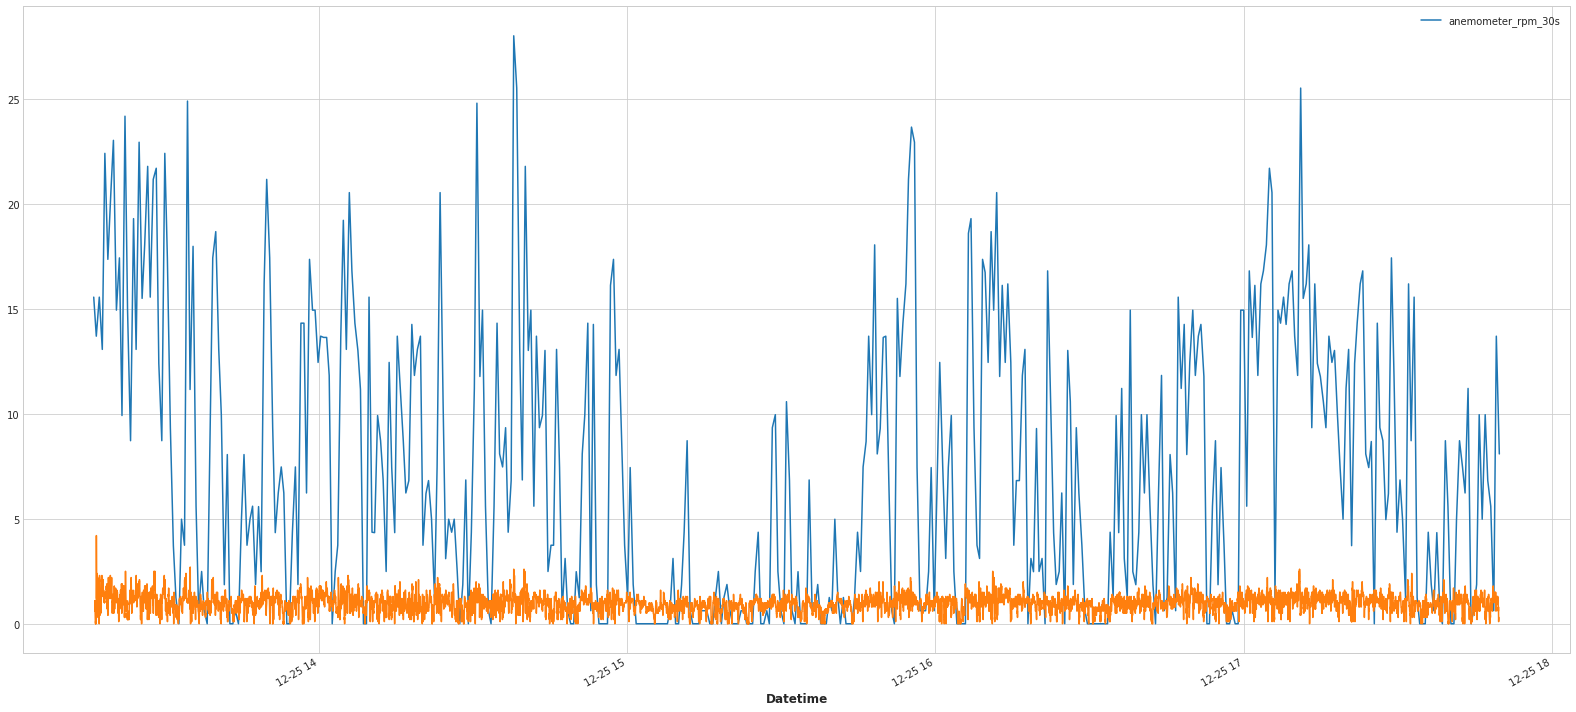

In [16]:
ax = df2.plot()
df.wind.plot(ax=ax)

So: to convert from RPM to wind speed, we need to math it up a bit.  The radius from the pivot point to the outer edge of the cups is 320mm, +/- 2mm.

In [17]:
from math import pi

radius_in_mm = 320
anemometer_circumference_in_mm = 2 * pi * radius_in_mm
anemometer_circumference_in_mm

2010.6192982974676

The naive way to measure wind speed is to say that one rotation means air has travelled one circumference length.

In [18]:
anemometer_circumference_in_m = anemometer_circumference_in_mm / 1000

# Calculate 1 RPM in metres per second
rpm = 1
windspeed_metres_per_second = rpm * anemometer_circumference_in_m / 60
windspeed_metres_per_second

0.03351032163829113

Let's do that calculation with df2.

In [19]:
df2["wind_speed_meters_per_second"] = df2["anemometer_rpm_30s"] * anemometer_circumference_in_m / 60
df2

,anemometer_rpm_30s,wind_speed_meters_per_second
time,,
2021-12-25 13:16:10-08:00,15.56,0.521421
2021-12-25 13:16:40-08:00,13.70,0.459091
2021-12-25 13:17:15-08:00,15.56,0.521421
2021-12-25 13:17:50-08:00,13.07,0.437980
2021-12-25 13:18:20-08:00,22.41,0.750966
...,...,...
2021-12-25 17:47:30-08:00,6.82,0.228540
2021-12-25 17:48:05-08:00,5.60,0.187658
2021-12-25 17:48:40-08:00,0.62,0.020776


How does this compare?

<AxesSubplot:xlabel='Datetime'>

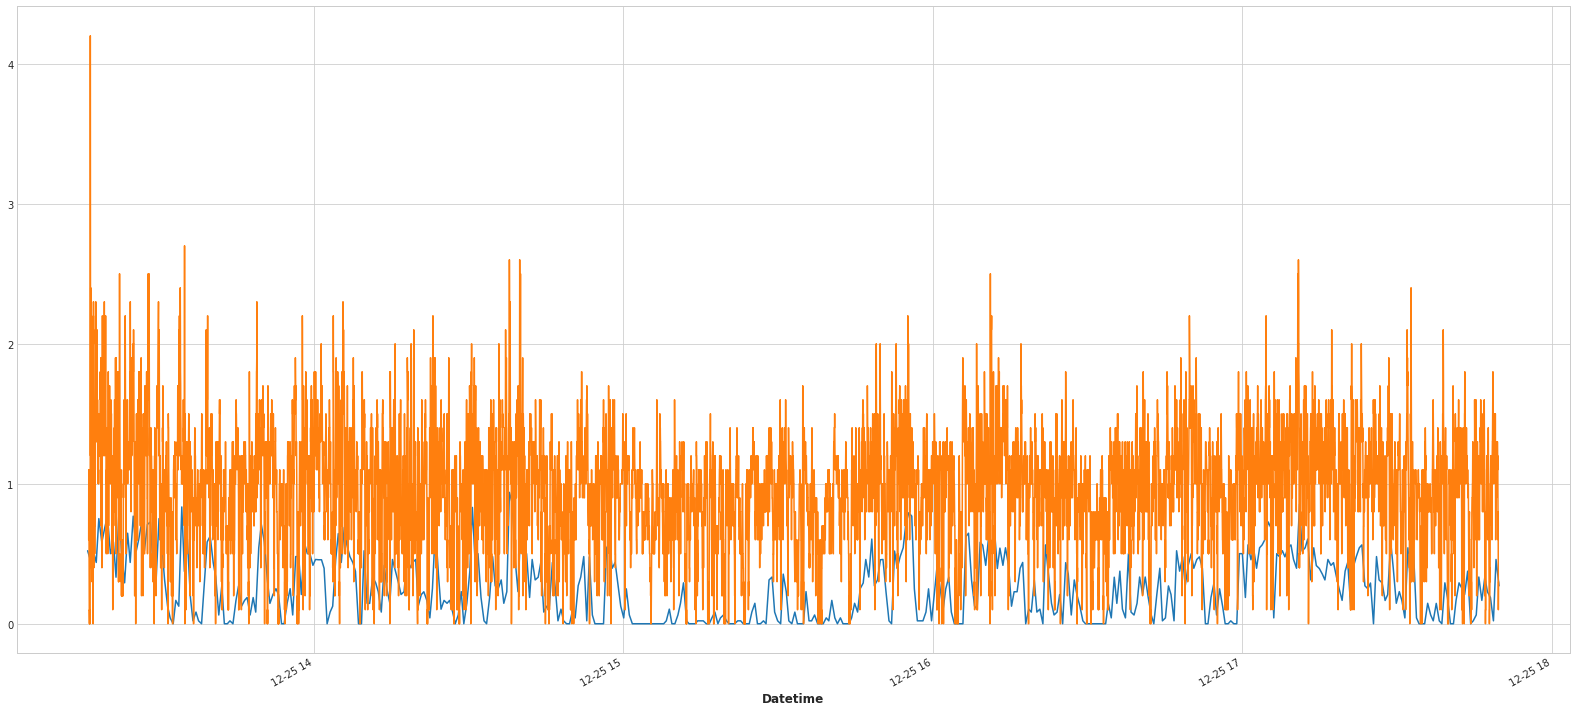

In [20]:
ax = df2["wind_speed_meters_per_second"].plot()
df.wind.plot(ax=ax)

Again, pretty noisy.  Let's convert both of those to rolling 10m averages & see how it looks.

In [21]:
df["wind_10m_rolling_average"] = df["wind"].rolling(window=600).mean()
df2["wind_speed_meters_per_second_10m_rolling_average"] = df2["wind_speed_meters_per_second"].rolling(window=20).mean()

<AxesSubplot:xlabel='Datetime'>

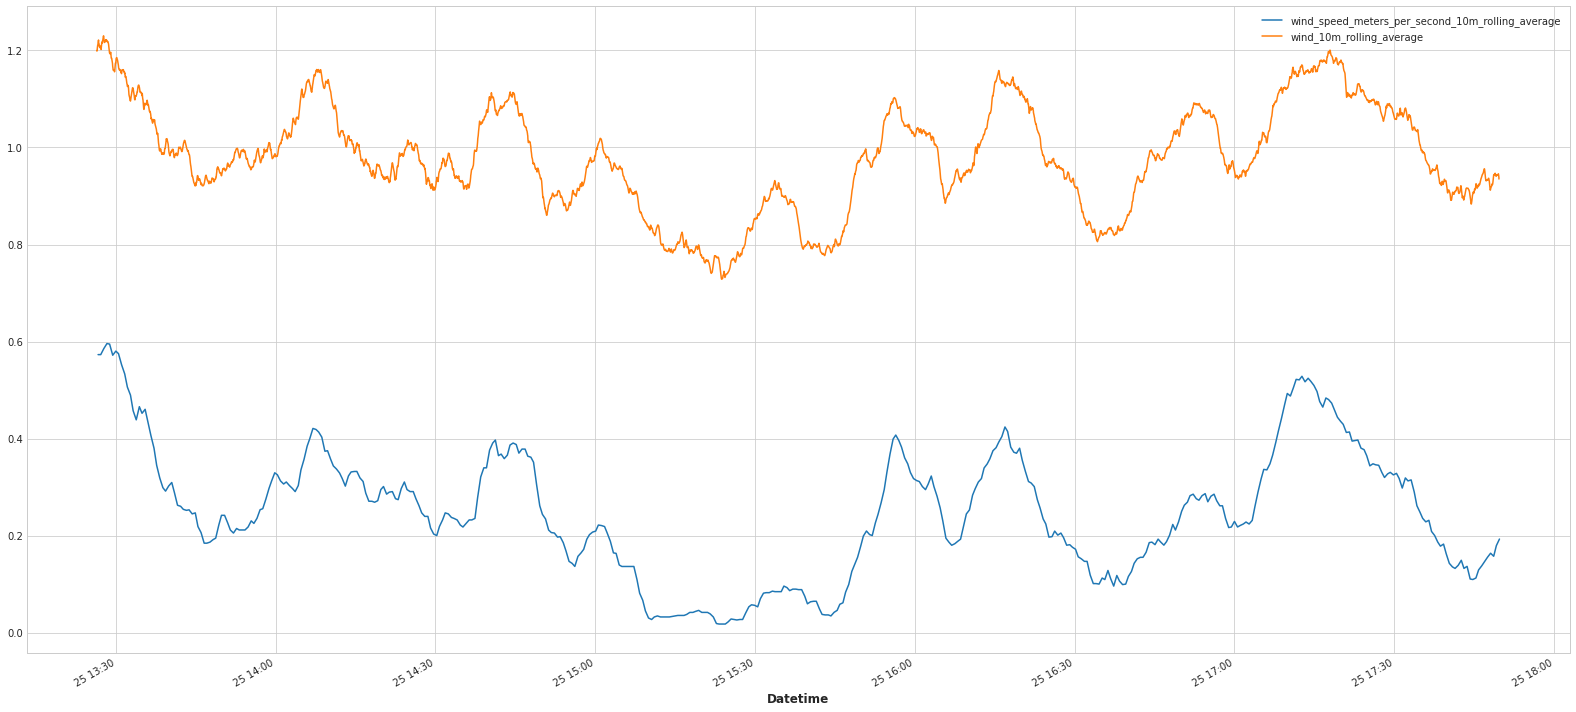

In [22]:
ax = df2["wind_speed_meters_per_second_10m_rolling_average"].plot(legend=True)
df["wind_10m_rolling_average"].plot(ax=ax, legend=True)

Not bad!

Up above I said that the "naive" way to calculate wind speed from RPM was to just use the circumference.  From https://en.wikipedia.org/wiki/Anemometer:

> Theoretically, the speed of rotation of the anemometer should be proportional to the wind speed because the force produced on an object is proportional to the speed of the fluid flowing past it. However, in practice other factors influence the rotational speed, including turbulence produced by the apparatus, increasing drag in opposition to the torque that is produced by the cups and support arms, and friction of the mount point. When Robinson first designed his anemometer, he asserted that the cups moved one-third of the speed of the wind, unaffected by the cup size or arm length. This was apparently confirmed by some early independent experiments, but it was incorrect. Instead, the ratio of the speed of the wind and that of the cups, the anemometer factor, depends on the dimensions of the cups and arms, and may have a value between two and a little over three. Every previous experiment involving an anemometer had to be repeated after the error was discovered. 

So: Very roughly, I see a factor of 2 in the graph above.  Let's try graphing the two with an **assumed** anemometer factor of 2.5.

Text(0.5, 0, 'Date time')

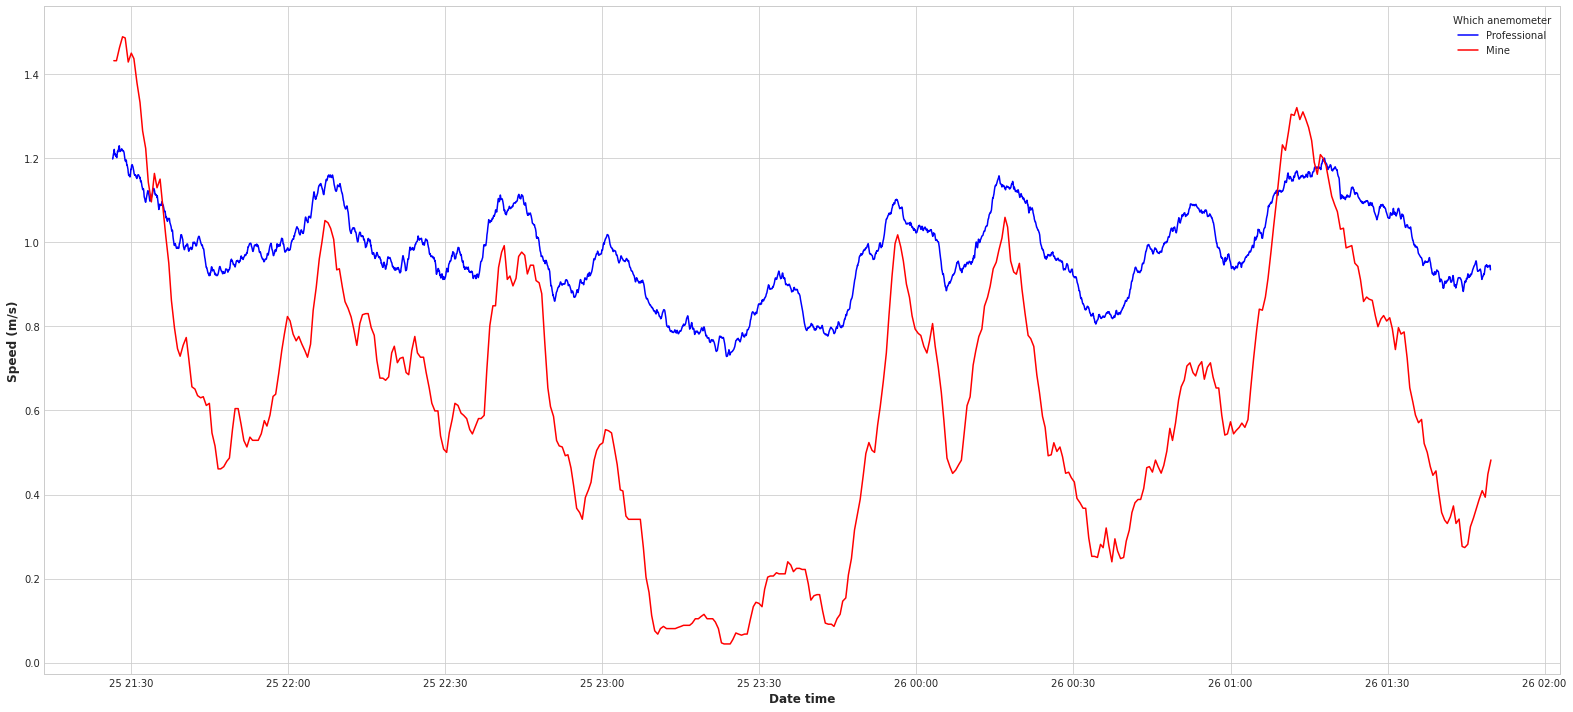

In [23]:
prof_anem_moving_avg = df["wind_10m_rolling_average"]
my_anem_moving_avg = df2["wind_speed_meters_per_second_10m_rolling_average"]

ASSUMED_ANEM_FACTOR = 2.5
plt.plot(prof_anem_moving_avg, color="blue", label="Professional")
plt.plot(my_anem_moving_avg * ASSUMED_ANEM_FACTOR , color="red", label="Mine")
# plt.plot(prof_anem_moving_avg / my_anem_moving_avg, color="green", label="Anemometer factor")
plt.legend(title="Which anemometer")
plt.ylabel("Speed (m/s)")
plt.xlabel("Date time")



This is interesting: the shape generally matches (peaks are peaks, valleys are valleys), but the ratio is quite different.  My suspicion is that this is due to the directionality of the professional anemometer.

Assuming that's the case, there would be a range in anemometer factors as winds change direction.  Let's graph the ratio of the two measurements; we'll resample to 1 minute intervals to make sure everything lines up.

Note: it could *also* be the case that below a certain speed, the homebrew anemometer response is non-linear.  

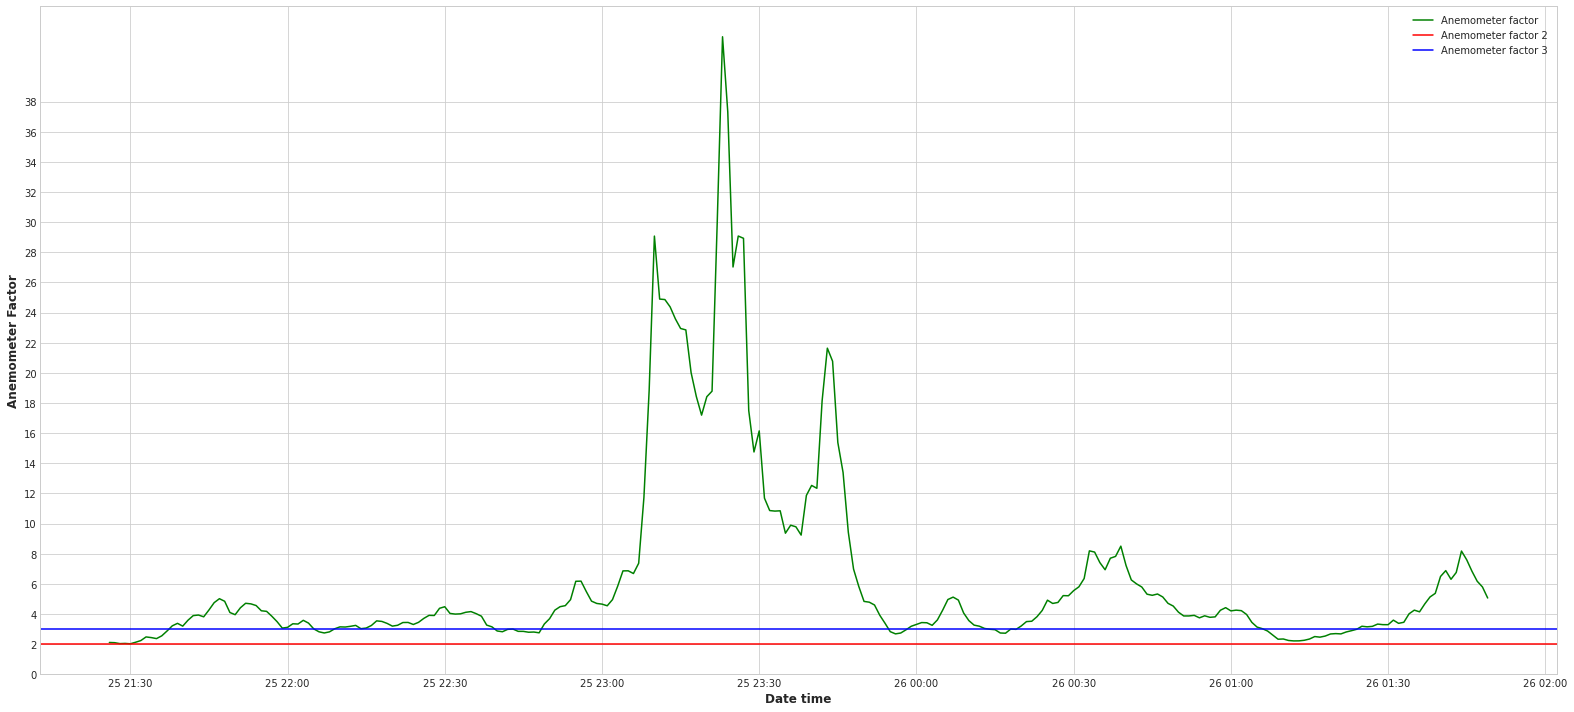

In [24]:
prof_anem_moving_avg = df["wind_10m_rolling_average"].resample("1T").mean()
my_anem_moving_avg = df2["wind_speed_meters_per_second_10m_rolling_average"].resample("1T").mean()

#plt.plot(prof_anem_moving_avg, color="blue", label="Professional")
#plt.plot(my_anem_moving_avg * 2.5, color="red", label="Mine")
plt.plot(prof_anem_moving_avg / my_anem_moving_avg, color="green", label="Anemometer factor")
plt.axhline(y=2.0, color='r', linestyle='-', label="Anemometer factor 2")
plt.axhline(y=3.0, color='b', linestyle='-', label="Anemometer factor 3")
plt.legend()
plt.ylabel("Anemometer Factor")
plt.xlabel("Date time")
plt.yticks(np.arange(0, 40, 2))
plt.show()

Interesting -- there are definitely a number of different regimes here:

* The big spike in the middle is obvious.  Here, the professional anemometer was registering speeds up to 40 times higher than the homebrew anemomemeter.
* There are a couple of smaller spikes where the ratio climbs to around 7.5.
* Most of of the time, the factor seems to vary between 2 and 5.

It might be interesting to see how resampling changes things...let's try that.

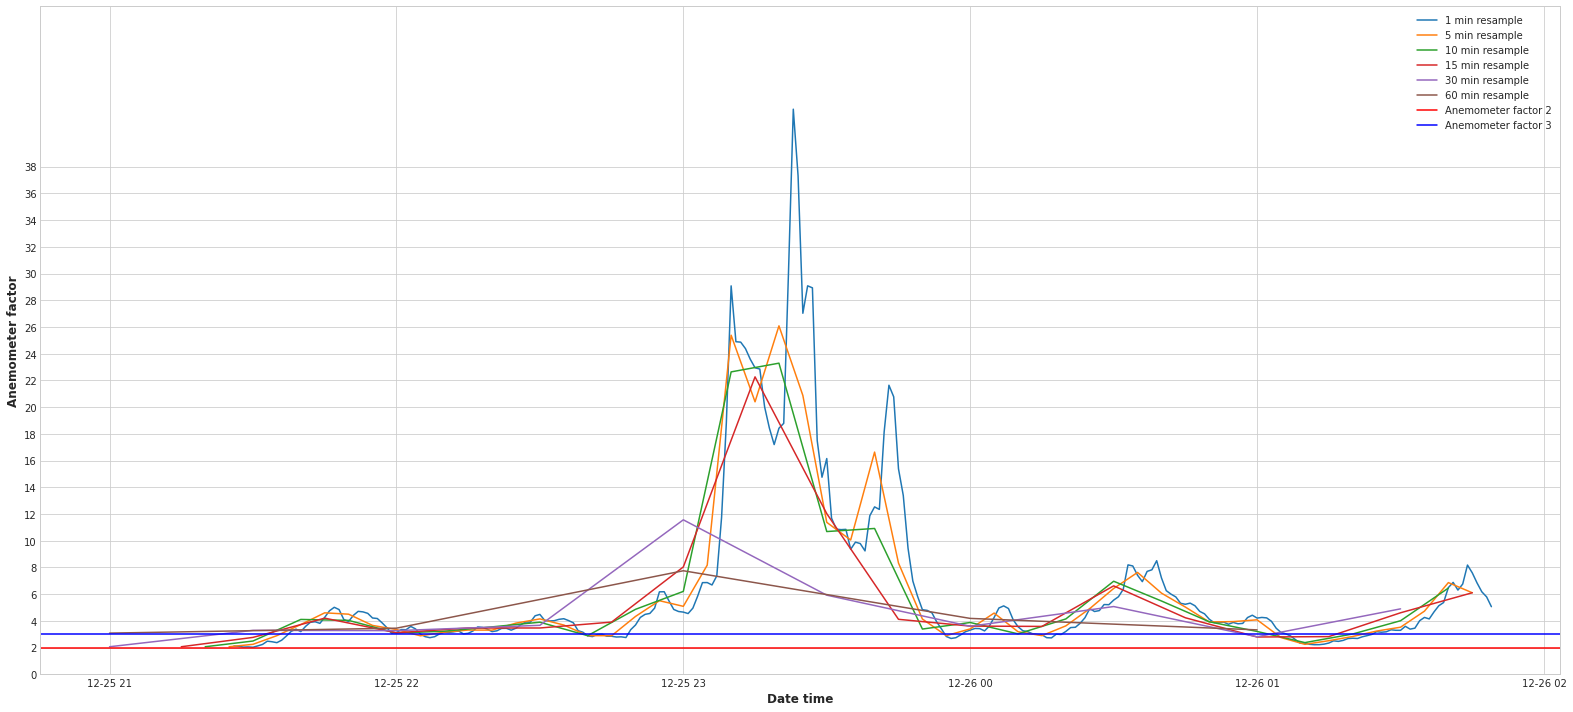

In [25]:
def plot_resamples(sample_times=[1, 5, 10, 15, 30, 60], ylim=[0, 50]):
    for i in sample_times:
        prof_anem = df["wind_10m_rolling_average"].resample(f"{i}T").mean()
        my_anem = df2["wind_speed_meters_per_second_10m_rolling_average"].resample(f"{i}T").mean()
        plt.plot(prof_anem / my_anem, label=f"{i} min resample")

    plt.axhline(y=2.0, color='r', linestyle='-', label="Anemometer factor 2")
    plt.axhline(y=3.0, color='b', linestyle='-', label="Anemometer factor 3")
    plt.legend()
    plt.ylabel("Anemometer factor")
    plt.xlabel("Date time")
    plt.yticks(np.arange(0, 40, 2))
    plt.ylim(ylim)
    plt.show()
    
plot_resamples()

Let's try that one more time, but with the y axis clamped to 10:

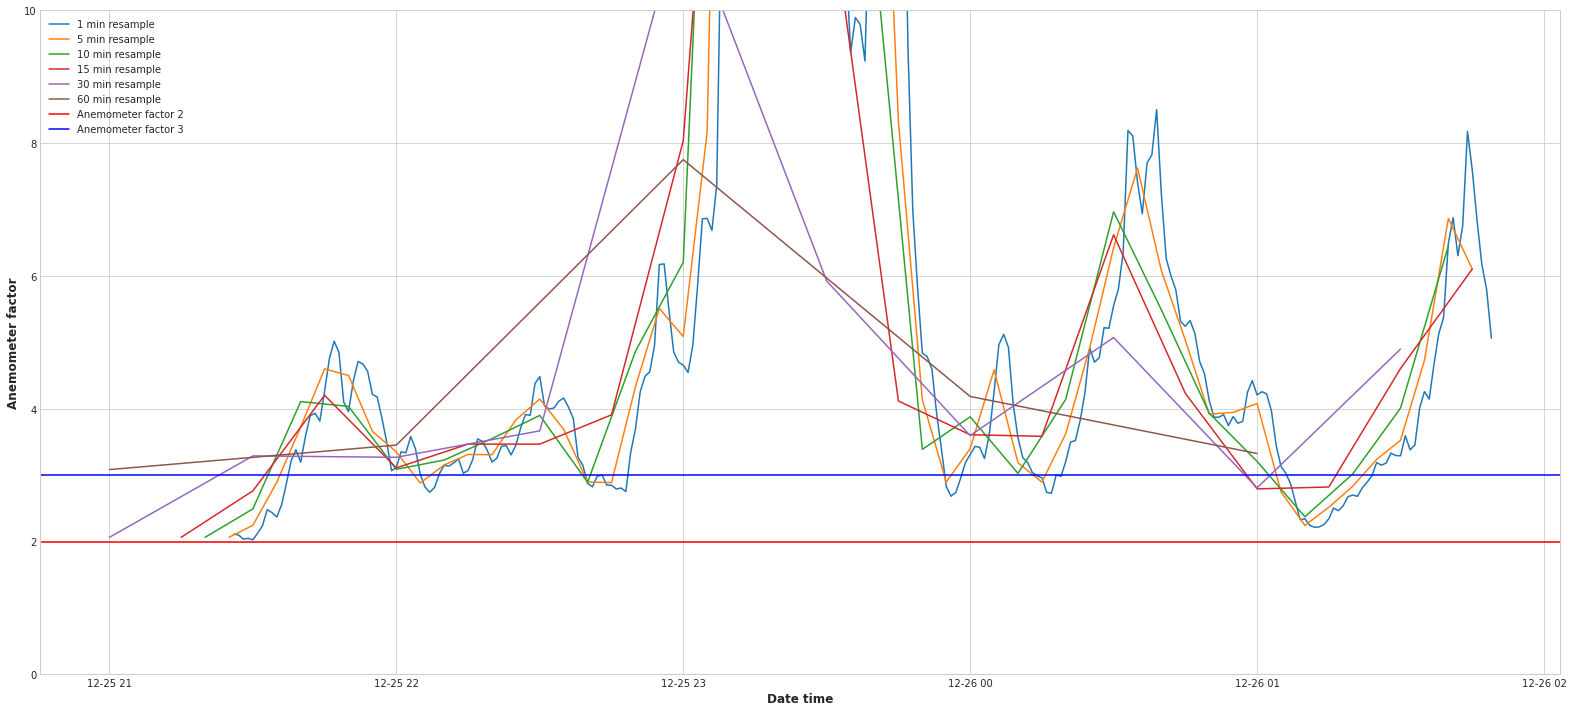

In [26]:
plot_resamples(ylim=[0, 10])

# FIXME:

- Name df something like "ground truth" or "professional anemometer"